# 🧪 A/B 테스트 데이터 분석
## 새 결제 페이지 UI 테스트

---

### 📋 목차
1. 환경 설정 및 데이터 로드
2. 데이터 탐색 (EDA)
3. A/B 테스트 핵심 지표 분석
4. 통계적 유의성 검정
5. 세그먼트별 분석
6. 전환 고객 심층 분석
7. 시계열 추이 분석
8. 시각화 대시보드
9. 최종 결론 및 권고안

---
## 1. 환경 설정 및 데이터 로드

In [ ]:
# 필요한 라이브러리 설치 (처음 한 번만 실행)
!pip install pandas numpy matplotlib seaborn scipy

In [2]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 시각화 설정
plt.style.use('seaborn-v0_8-whitegrid')

# 한글 폰트 설정 (Windows)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# Mac인 경우 아래 주석 해제
# plt.rcParams['font.family'] = 'AppleGothic'

# pandas 출력 설정
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

print("✅ 라이브러리 로드 완료!")

✅ 라이브러리 로드 완료!


In [43]:
# 데이터 파일 경로 설정
# DATA_PATH = r"C:\Users\Administrator\Documents\A_B_TEST\AB_Test_Checkout_UI\data\raw"  # 데이터 파일이 있는 폴더 경로로 수정하세요
DATA_PATH = "C:/Users/Administrator/Documents/A_B_TEST/AB_Test_Checkout_UI/data/raw/"


# 베이스 데이터 로드
customers = pd.read_csv(f"{DATA_PATH}kr_customers.csv")
orders = pd.read_csv(f"{DATA_PATH}kr_orders.csv")
products = pd.read_csv(f"{DATA_PATH}kr_products.csv")
order_items = pd.read_csv(f"{DATA_PATH}kr_order_items.csv")
payments = pd.read_csv(f"{DATA_PATH}kr_payments.csv")

# A/B 테스트 데이터 로드
ab_test = pd.read_csv(f"{DATA_PATH}ab_test_checkout_ui.csv")

print("📂 데이터 로드 완료!")
print(f"  - 고객: {len(customers):,}건")
print(f"  - 주문: {len(orders):,}건")
print(f"  - 상품: {len(products):,}건")
print(f"  - 주문상품: {len(order_items):,}건")
print(f"  - 결제: {len(payments):,}건")
print(f"  - A/B 테스트: {len(ab_test):,}건")

📂 데이터 로드 완료!
  - 고객: 20,000건
  - 주문: 35,000건
  - 상품: 500건
  - 주문상품: 61,309건
  - 결제: 35,000건
  - A/B 테스트: 20,000건


---
## 2. 데이터 탐색 (EDA)

### 2.1 A/B 테스트 데이터 구조 확인

In [44]:
# 데이터 구조 확인
print("[A/B 테스트 데이터 정보]")
ab_test.info()

[A/B 테스트 데이터 정보]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        20000 non-null  object 
 1   region             20000 non-null  object 
 2   age_group          20000 non-null  object 
 3   gender             20000 non-null  object 
 4   device             20000 non-null  object 
 5   test_group         20000 non-null  object 
 6   visit_date         20000 non-null  object 
 7   converted          20000 non-null  int64  
 8   order_value        20000 non-null  int64  
 9   checkout_time_sec  3089 non-null   float64
 10  payment_method     3089 non-null   object 
dtypes: float64(1), int64(2), object(8)
memory usage: 1.7+ MB


In [45]:
# 상위 10개 데이터 확인
ab_test.head(10)

,customer_id,region,age_group,gender,device,test_group,visit_date,converted,order_value,checkout_time_sec,payment_method
0,CUST_000001,경남,30대,여성,모바일,control,2024-05-06,0,0,NaN,NaN
1,CUST_000002,경기,30대,남성,데스크톱,control,2024-05-05,1,105945,227.00,네이버페이
2,CUST_000003,경기,30대,여성,모바일,treatment,2024-05-08,0,0,NaN,NaN
3,CUST_000004,전북,30대,남성,모바일,control,2024-05-06,0,0,NaN,NaN
4,CUST_000005,인천,60대 이상,여성,데스크톱,control,2024-05-17,0,0,NaN,NaN
5,CUST_000006,대구,30대,남성,모바일,control,2024-05-16,1,126501,369.00,신용카드
6,CUST_000007,서울,50대,여성,데스크톱,control,2024-05-11,0,0,NaN,NaN
7,CUST_000008,강원,20대,여성,모바일,treatment,2024-05-01,1,77322,172.00,네이버페이
8,CUST_000009,충북,40대,여성,태블릿,control,2024-05-14,0,0,NaN,NaN
9,CUST_000010,경기,20대,남성,모바일,treatment,2024-05-13,1,145798,169.00,네이버페이


In [46]:
# 기술 통계량
ab_test.describe()

,converted,order_value,checkout_time_sec
count,20000.00,20000.00,3089.00
mean,0.15,13117.24,146.01
std,0.36,34635.14,59.02
min,0.00,0.00,30.00
25%,0.00,0.00,104.00
50%,0.00,0.00,140.00
75%,0.00,0.00,184.00
max,1.00,236320.00,378.00


### 2.2 범주형 변수 분포 확인

In [47]:
# A/B 그룹 분포
print("[A/B 그룹 분포]")
print(ab_test['test_group'].value_counts())
print(f"\n비율: {ab_test['test_group'].value_counts(normalize=True).round(3)}")

[A/B 그룹 분포]
test_group
treatment    10069
control       9931
Name: count, dtype: int64

비율: test_group
treatment   0.50
control     0.50
Name: proportion, dtype: float64


In [13]:
# 전환 여부 분포
print("[전환 여부 분포]")
print(ab_test['converted'].value_counts())
print(f"\n전체 전환율: {ab_test['converted'].mean():.2%}")

[전환 여부 분포]
converted
0    16911
1     3089
Name: count, dtype: int64

전체 전환율: 15.45%


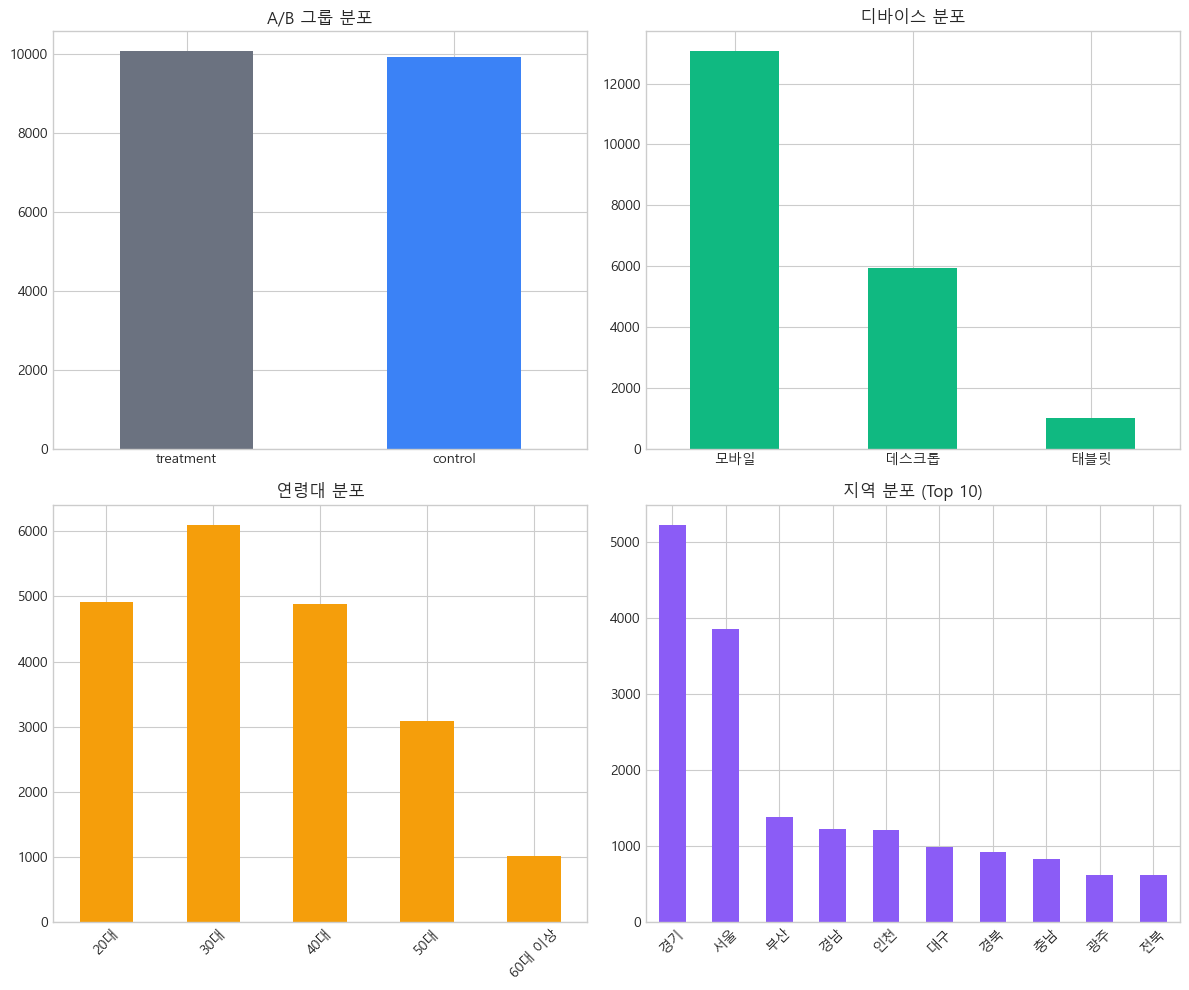

In [48]:
# 범주형 변수 분포 시각화
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 그룹 분포
ab_test['test_group'].value_counts().plot(kind='bar', ax=axes[0, 0], color=['#6B7280', '#3B82F6'])
axes[0, 0].set_title('A/B 그룹 분포')
axes[0, 0].set_xlabel('')
axes[0, 0].tick_params(axis='x', rotation=0)

# 디바이스 분포
ab_test['device'].value_counts().plot(kind='bar', ax=axes[0, 1], color='#10B981')
axes[0, 1].set_title('디바이스 분포')
axes[0, 1].set_xlabel('')
axes[0, 1].tick_params(axis='x', rotation=0)

# 연령대 분포
age_order = ['20대', '30대', '40대', '50대', '60대 이상']
ab_test['age_group'].value_counts().reindex(age_order).plot(kind='bar', ax=axes[1, 0], color='#F59E0B')
axes[1, 0].set_title('연령대 분포')
axes[1, 0].set_xlabel('')
axes[1, 0].tick_params(axis='x', rotation=45)

# 지역 분포 (상위 10개)
ab_test['region'].value_counts().head(10).plot(kind='bar', ax=axes[1, 1], color='#8B5CF6')
axes[1, 1].set_title('지역 분포 (Top 10)')
axes[1, 1].set_xlabel('')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 2.3 그룹 간 동질성 확인
A/B 테스트의 신뢰성을 위해 두 그룹의 특성이 비슷한지 확인합니다.

In [49]:
# 그룹별 디바이스 분포
print("[그룹별 디바이스 분포]")
device_dist = pd.crosstab(ab_test['test_group'], ab_test['device'], normalize='index') * 100
print(device_dist.round(2))

[그룹별 디바이스 분포]
device      데스크톱   모바일  태블릿
test_group                 
control    29.53 65.56 4.90
treatment  29.81 65.09 5.09


In [16]:
# 그룹별 연령대 분포
print("[그룹별 연령대 분포]")
age_dist = pd.crosstab(ab_test['test_group'], ab_test['age_group'], normalize='index') * 100
print(age_dist.round(2))

[그룹별 연령대 분포]
age_group    20대   30대   40대   50대  60대 이상
test_group                                
control    24.84 29.99 24.52 15.47    5.19
treatment  24.35 31.01 24.33 15.39    4.92


In [50]:
# Chi-square 검정으로 그룹 간 동질성 확인
chi2_device, p_device, _, _ = stats.chi2_contingency(pd.crosstab(ab_test['test_group'], ab_test['device']))
chi2_age, p_age, _, _ = stats.chi2_contingency(pd.crosstab(ab_test['test_group'], ab_test['age_group']))

print("[그룹 간 동질성 검정]")
print(f"  디바이스: chi2={chi2_device:.4f}, p-value={p_device:.4f} {'✅ 동질' if p_device > 0.05 else '⚠️ 이질'}")
print(f"  연령대: chi2={chi2_age:.4f}, p-value={p_age:.4f} {'✅ 동질' if p_age > 0.05 else '⚠️ 이질'}")

[그룹 간 동질성 검정]
  디바이스: chi2=0.6675, p-value=0.7162 ✅ 동질
  연령대: chi2=2.9986, p-value=0.5581 ✅ 동질


---
## 3. A/B 테스트 핵심 지표 분석

### 3.1 전환율 비교

In [51]:
# 그룹별 전환율 계산
conversion_summary = ab_test.groupby('test_group').agg({
    'customer_id': 'count',
    'converted': ['sum', 'mean']
})
conversion_summary.columns = ['총_방문자', '전환_수', '전환율']
conversion_summary['전환율(%)'] = (conversion_summary['전환율'] * 100).round(2)

print("[그룹별 전환율]")
conversion_summary

[그룹별 전환율]


,총_방문자,전환_수,전환율,전환율(%)
test_group,,,,
control,9931,1287,0.13,12.96
treatment,10069,1802,0.18,17.90


In [52]:
# 전환율 차이 계산
control_rate = ab_test[ab_test['test_group'] == 'control']['converted'].mean()
treatment_rate = ab_test[ab_test['test_group'] == 'treatment']['converted'].mean()

absolute_diff = treatment_rate - control_rate
relative_lift = (treatment_rate - control_rate) / control_rate * 100

print("="*50)
print("📊 전환율 비교 결과")
print("="*50)
print(f"  Control (기존 UI):    {control_rate:.2%}")
print(f"  Treatment (새 UI):    {treatment_rate:.2%}")
print(f"  ─────────────────────────────")
print(f"  절대적 차이:          +{absolute_diff:.2%}p")
print(f"  상대적 개선율 (Lift): +{relative_lift:.1f}%")
print("="*50)

📊 전환율 비교 결과
  Control (기존 UI):    12.96%
  Treatment (새 UI):    17.90%
  ─────────────────────────────
  절대적 차이:          +4.94%p
  상대적 개선율 (Lift): +38.1%


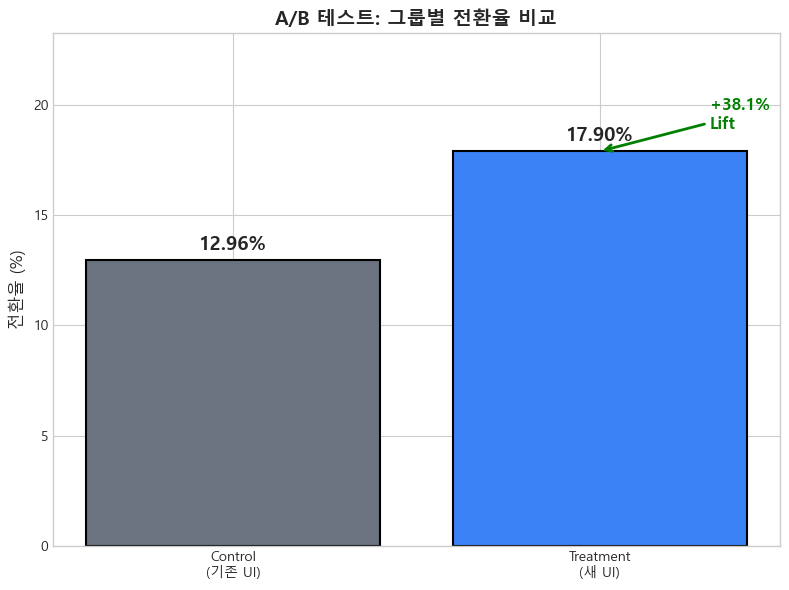

In [53]:
# 전환율 비교 시각화
fig, ax = plt.subplots(figsize=(8, 6))

colors = {'control': '#6B7280', 'treatment': '#3B82F6'}
bars = ax.bar(['Control\n(기존 UI)', 'Treatment\n(새 UI)'], 
              [control_rate * 100, treatment_rate * 100],
              color=[colors['control'], colors['treatment']],
              edgecolor='black', linewidth=1.5)

# 값 표시
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.3,
            f'{height:.2f}%', ha='center', va='bottom', fontsize=14, fontweight='bold')

# Lift 화살표
ax.annotate(f'+{relative_lift:.1f}%\nLift', 
            xy=(1, treatment_rate*100), 
            xytext=(1.3, treatment_rate*100 + 1),
            fontsize=12, color='green', fontweight='bold',
            arrowprops=dict(arrowstyle='->', color='green', lw=2))

ax.set_ylabel('전환율 (%)', fontsize=12)
ax.set_title('A/B 테스트: 그룹별 전환율 비교', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(control_rate, treatment_rate) * 100 * 1.3)

plt.tight_layout()
plt.show()

---
## 4. 통계적 유의성 검정

### 4.1 Chi-Square 검정

In [54]:
# 교차표 생성
contingency_table = pd.crosstab(ab_test['test_group'], ab_test['converted'])
contingency_table.columns = ['미전환', '전환']
print("[교차표]")
print(contingency_table)

[교차표]
             미전환    전환
test_group            
control     8644  1287
treatment   8267  1802


In [55]:
# Chi-square 검정 수행
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print("="*50)
print("📐 Chi-Square 검정 결과")
print("="*50)
print(f"  Chi-square 통계량: {chi2:.4f}")
print(f"  자유도 (df):       {dof}")
print(f"  p-value:           {p_value:.6f}")
print(f"  ─────────────────────────────")
if p_value < 0.001:
    print(f"  결과: ✅ 매우 유의미 (p < 0.001)")
elif p_value < 0.01:
    print(f"  결과: ✅ 유의미 (p < 0.01)")
elif p_value < 0.05:
    print(f"  결과: ✅ 유의미 (p < 0.05)")
else:
    print(f"  결과: ❌ 유의미하지 않음 (p >= 0.05)")
print("="*50)

📐 Chi-Square 검정 결과
  Chi-square 통계량: 92.9402
  자유도 (df):       1
  p-value:           0.000000
  ─────────────────────────────
  결과: ✅ 매우 유의미 (p < 0.001)


### 4.2 Z-Test for Proportions

In [56]:
# Z-test 수행
control_data = ab_test[ab_test['test_group'] == 'control']['converted']
treatment_data = ab_test[ab_test['test_group'] == 'treatment']['converted']

n_control = len(control_data)
n_treatment = len(treatment_data)
p_control = control_data.mean()
p_treatment = treatment_data.mean()

# Pooled proportion
p_pooled = (control_data.sum() + treatment_data.sum()) / (n_control + n_treatment)

# Standard error
se = np.sqrt(p_pooled * (1 - p_pooled) * (1/n_control + 1/n_treatment))

# Z-score
z_score = (p_treatment - p_control) / se

# Two-tailed p-value
p_value_z = 2 * (1 - stats.norm.cdf(abs(z_score)))

print("="*50)
print("📐 Z-Test for Proportions 결과")
print("="*50)
print(f"  n (Control):     {n_control:,}")
print(f"  n (Treatment):   {n_treatment:,}")
print(f"  Pooled Rate:     {p_pooled:.4f}")
print(f"  Standard Error:  {se:.6f}")
print(f"  Z-score:         {z_score:.4f}")
print(f"  p-value:         {p_value_z:.6f}")
print("="*50)

📐 Z-Test for Proportions 결과
  n (Control):     9,931
  n (Treatment):   10,069
  Pooled Rate:     0.1545
  Standard Error:  0.005111
  Z-score:         9.6601
  p-value:         0.000000


### 4.3 95% 신뢰구간 계산

In [ ]:
!pip install statsmodels

In [57]:
# 상단에 import 추가
from statsmodels.stats.proportion import proportion_confint

# 기존 코드 그대로 사용
ci_control = proportion_confint(control_data.sum(), n_control, alpha=0.05, method='wilson')
ci_treatment = proportion_confint(treatment_data.sum(), n_treatment, alpha=0.05, method='wilson')

In [58]:
# 95% 신뢰구간 계산 (Normal Approximation)
import numpy as np
from scipy import stats

def proportion_confint_manual(count, nobs, alpha=0.05):
    """비율의 신뢰구간 계산"""
    p = count / nobs
    z = stats.norm.ppf(1 - alpha/2)
    se = np.sqrt(p * (1 - p) / nobs)
    return (max(0, p - z * se), min(1, p + z * se))

ci_control = proportion_confint_manual(int(control_data.sum()), n_control)
ci_treatment = proportion_confint_manual(int(treatment_data.sum()), n_treatment)

print("="*50)
print("📊 95% 신뢰구간")
print("="*50)
print(f"  Control:   [{ci_control[0]:.2%}, {ci_control[1]:.2%}]")
print(f"  Treatment: [{ci_treatment[0]:.2%}, {ci_treatment[1]:.2%}]")
print(f"  ─────────────────────────────")
if ci_control[1] < ci_treatment[0]:
    print(f"  ✅ 신뢰구간이 겹치지 않음 → 통계적으로 유의미")
else:
    print(f"  ⚠️ 신뢰구간이 겹침 → 추가 검토 필요")
print("="*50)

📊 95% 신뢰구간
  Control:   [12.30%, 13.62%]
  Treatment: [17.15%, 18.65%]
  ─────────────────────────────
  ✅ 신뢰구간이 겹치지 않음 → 통계적으로 유의미


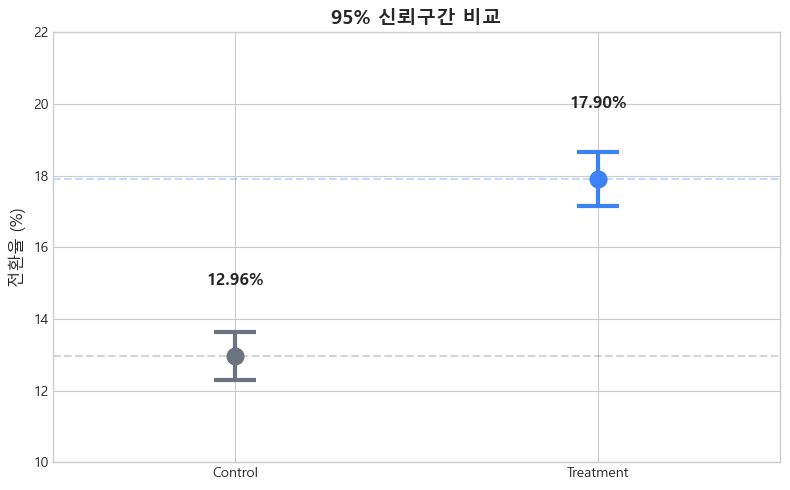

In [59]:
# 신뢰구간 시각화
fig, ax = plt.subplots(figsize=(8, 5))

groups = ['Control', 'Treatment']
means = [control_rate * 100, treatment_rate * 100]
ci_lower = [ci_control[0] * 100, ci_treatment[0] * 100]
ci_upper = [ci_control[1] * 100, ci_treatment[1] * 100]
errors = [[m - l for m, l in zip(means, ci_lower)], 
          [u - m for m, u in zip(means, ci_upper)]]

colors_list = ['#6B7280', '#3B82F6']

# 각 그룹별로 따로 그리기
for i, (group, mean, color) in enumerate(zip(groups, means, colors_list)):
    ax.errorbar(i, mean, 
                yerr=[[means[i] - ci_lower[i]], [ci_upper[i] - means[i]]], 
                fmt='o', markersize=12, capsize=15, capthick=3, 
                elinewidth=3, color=color, ecolor=color)

# x축 설정
ax.set_xticks([0, 1])
ax.set_xticklabels(groups)

# 값 표시
for i, (mean, color) in enumerate(zip(means, colors_list)):
    ax.text(i, mean + 2, f'{mean:.2f}%', ha='center', fontsize=12, fontweight='bold')

ax.set_ylabel('전환율 (%)', fontsize=12)
ax.set_title('95% 신뢰구간 비교', fontsize=14, fontweight='bold')
ax.set_ylim(10, 22)
ax.set_xlim(-0.5, 1.5)

# 기준선
ax.axhline(y=control_rate*100, color='#6B7280', linestyle='--', alpha=0.3)
ax.axhline(y=treatment_rate*100, color='#3B82F6', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

---
## 5. 세그먼트별 분석

### 5.1 디바이스별 전환율

In [60]:
# 디바이스별 전환율 분석
device_analysis = ab_test.groupby(['device', 'test_group']).agg({
    'converted': ['count', 'sum', 'mean']
}).round(4)
device_analysis.columns = ['샘플수', '전환수', '전환율']
device_analysis['전환율(%)'] = (device_analysis['전환율'] * 100).round(2)

print("[디바이스별 전환율 상세]")
device_analysis

[디바이스별 전환율 상세]


샘플수   전환수  전환율  전환율(%)
device test_group                         
데스크톱   control     2933   380 0.13   12.96
       treatment   3002   491 0.16   16.36
모바일    control     6511   845 0.13   12.98
       treatment   6554  1223 0.19   18.66
태블릿    control      487    62 0.13   12.73
       treatment    513    88 0.17   17.15

In [61]:
# 디바이스별 전환율 피벗
device_pivot = ab_test.pivot_table(
    values='converted', 
    index='device', 
    columns='test_group', 
    aggfunc='mean'
) * 100

device_pivot['차이(%p)'] = device_pivot['treatment'] - device_pivot['control']
device_pivot['Lift(%)'] = (device_pivot['treatment'] - device_pivot['control']) / device_pivot['control'] * 100

print("[디바이스별 전환율 비교]")
device_pivot.round(2)

[디바이스별 전환율 비교]


test_group,control,treatment,차이(%p),Lift(%)
device,,,,
데스크톱,12.96,16.36,3.40,26.24
모바일,12.98,18.66,5.68,43.78
태블릿,12.73,17.15,4.42,34.74


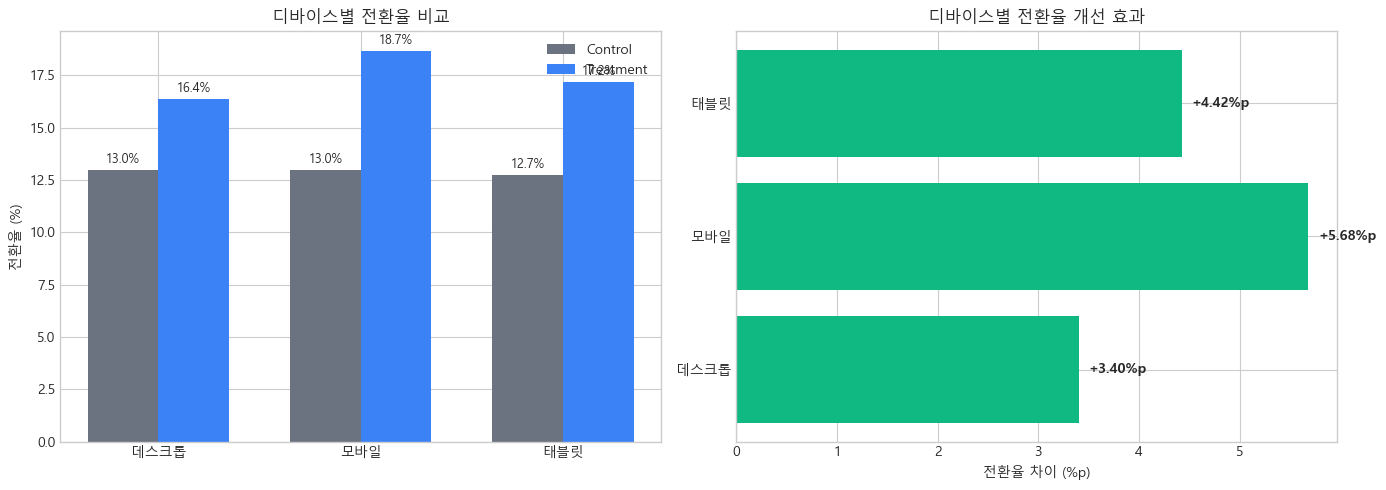

In [62]:
# 디바이스별 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 막대 그래프
x = np.arange(len(device_pivot.index))
width = 0.35

bars1 = axes[0].bar(x - width/2, device_pivot['control'], width, 
                    label='Control', color='#6B7280')
bars2 = axes[0].bar(x + width/2, device_pivot['treatment'], width, 
                    label='Treatment', color='#3B82F6')

axes[0].set_ylabel('전환율 (%)')
axes[0].set_title('디바이스별 전환율 비교')
axes[0].set_xticks(x)
axes[0].set_xticklabels(device_pivot.index)
axes[0].legend()

# 값 표시
for bar in bars1:
    axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.2,
                 f'{bar.get_height():.1f}%', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.2,
                 f'{bar.get_height():.1f}%', ha='center', va='bottom', fontsize=9)

# Lift 막대 그래프
colors = ['#10B981' if x > 0 else '#EF4444' for x in device_pivot['차이(%p)']]
axes[1].barh(device_pivot.index, device_pivot['차이(%p)'], color=colors)
axes[1].set_xlabel('전환율 차이 (%p)')
axes[1].set_title('디바이스별 전환율 개선 효과')
axes[1].axvline(x=0, color='black', linewidth=0.5)

# 값 표시
for i, v in enumerate(device_pivot['차이(%p)']):
    axes[1].text(v + 0.1, i, f'+{v:.2f}%p', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

### 5.2 연령대별 전환율

In [5]:
# 연령대별 전환율 피벗
age_order = ['20대', '30대', '40대', '50대', '60대 이상']
age_pivot = ab_test.pivot_table(
    values='converted', 
    index='age_group', 
    columns='test_group', 
    aggfunc='mean'
) * 100

age_pivot = age_pivot.reindex(age_order)
age_pivot['차이(%p)'] = age_pivot['treatment'] - age_pivot['control']
age_pivot['Lift(%)'] = (age_pivot['treatment'] - age_pivot['control']) / age_pivot['control'] * 100

print("[연령대별 전환율 비교]")
age_pivot.round(2)

[연령대별 전환율 비교]


test_group,control,treatment,차이(%p),Lift(%)
age_group,,,,
20대,13.66,20.43,6.77,49.57
30대,12.12,18.35,6.23,51.40
40대,12.44,16.69,4.25,34.16
50대,14.26,15.35,1.10,7.69
60대 이상,13.01,16.36,3.35,25.78


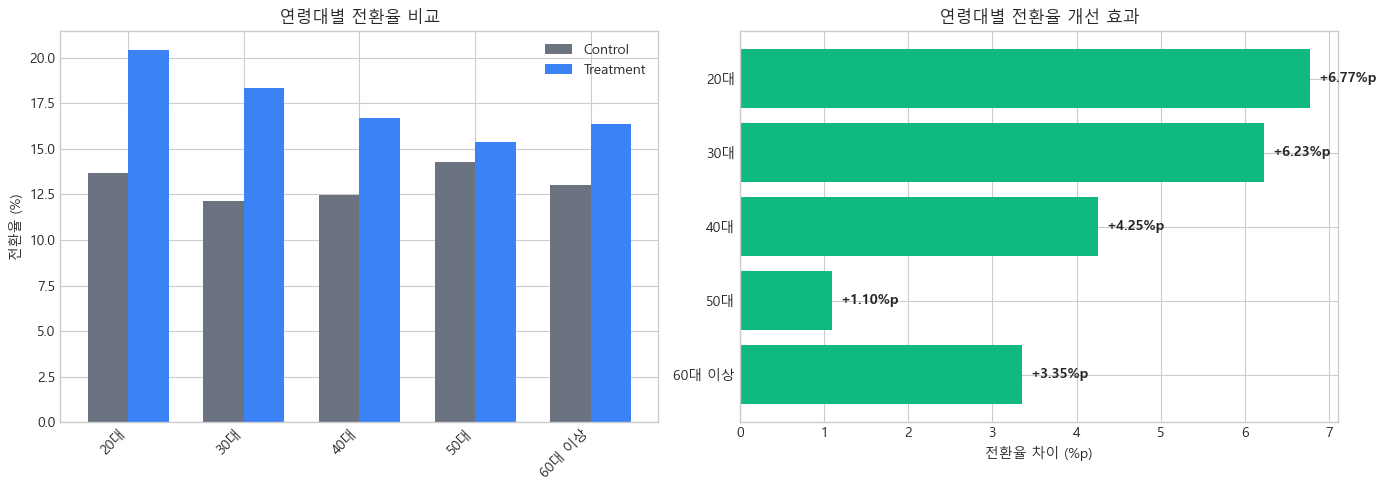

In [23]:
# 연령대별 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 막대 그래프
x = np.arange(len(age_pivot.index))
width = 0.35

bars1 = axes[0].bar(x - width/2, age_pivot['control'], width, 
                    label='Control', color='#6B7280')
bars2 = axes[0].bar(x + width/2, age_pivot['treatment'], width, 
                    label='Treatment', color='#3B82F6')

axes[0].set_ylabel('전환율 (%)')
axes[0].set_title('연령대별 전환율 비교')
axes[0].set_xticks(x)
axes[0].set_xticklabels(age_pivot.index, rotation=45, ha='right')
axes[0].legend()

# Lift 막대 그래프
age_pivot_reversed = age_pivot.iloc[::-1]  # 역순 정렬

colors = ['#10B981' if x > 0 else '#EF4444' for x in age_pivot_reversed['차이(%p)']]
axes[1].barh(age_pivot_reversed.index, age_pivot_reversed['차이(%p)'], color=colors)
axes[1].set_xlabel('전환율 차이 (%p)')
axes[1].set_title('연령대별 전환율 개선 효과')
axes[1].axvline(x=0, color='black', linewidth=0.5)

for i, v in enumerate(age_pivot_reversed['차이(%p)']):
    axes[1].text(v + 0.1, i, f'+{v:.2f}%p', va='center', fontweight='bold')


plt.tight_layout()
plt.show()

### 5.3 지역별 전환율

In [7]:
# 지역별 전환율
region_pivot = ab_test.pivot_table(
    values='converted', 
    index='region', 
    columns='test_group', 
    aggfunc='mean'
) * 100

region_pivot['차이(%p)'] = region_pivot['treatment'] - region_pivot['control']
region_pivot = region_pivot.sort_values('차이(%p)', ascending=False)

print("[지역별 전환율 개선 효과 Top 10]")
region_pivot.head(10).round(2)

[지역별 전환율 개선 효과 Top 10]


test_group,control,treatment,차이(%p)
region,,,
전남,9.36,17.95,8.59
강원,11.50,20.00,8.50
울산,14.56,22.93,8.36
광주,10.38,18.51,8.13
충북,16.06,23.73,7.67
대구,11.18,16.77,5.60
경북,13.41,18.79,5.38
부산,12.02,17.24,5.21
경기,13.35,18.32,4.97


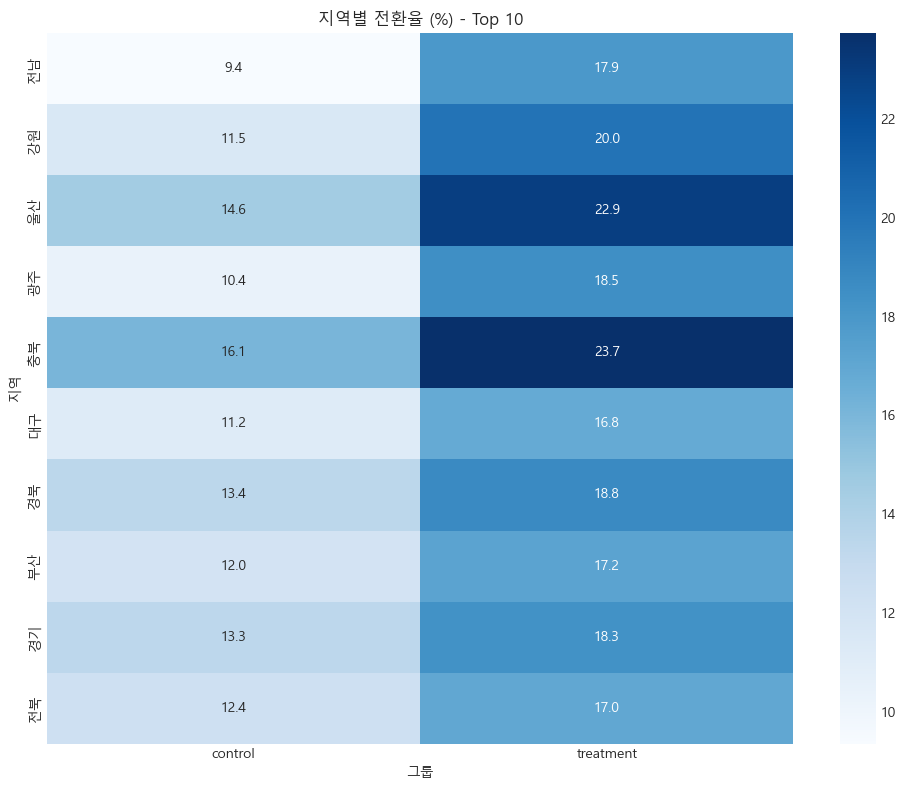

In [8]:
# 지역별 히트맵
fig, ax = plt.subplots(figsize=(10, 8))

region_heatmap = region_pivot[['control', 'treatment']].head(10)
sns.heatmap(region_heatmap, annot=True, fmt='.1f', cmap='Blues', ax=ax)
ax.set_title('지역별 전환율 (%) - Top 10')
ax.set_xlabel('그룹')
ax.set_ylabel('지역')

plt.tight_layout()
plt.show()

### 5.4 세그먼트 교차 분석 (연령 × 디바이스)

In [9]:
# 연령대 × 디바이스 교차 분석 (Treatment 그룹)
cross_analysis = ab_test[ab_test['test_group'] == 'treatment'].pivot_table(
    values='converted',
    index='age_group',
    columns='device',
    aggfunc='mean'
) * 100

cross_analysis = cross_analysis.reindex(age_order)

print("[Treatment 그룹: 연령대 × 디바이스 전환율]")
cross_analysis.round(2)

[Treatment 그룹: 연령대 × 디바이스 전환율]


device,데스크톱,모바일,태블릿
age_group,,,
20대,20.40,20.56,18.80
30대,17.62,18.58,17.86
40대,15.19,17.53,16.67
50대,15.07,15.92,13.33
60대 이상,13.06,19.82,17.39


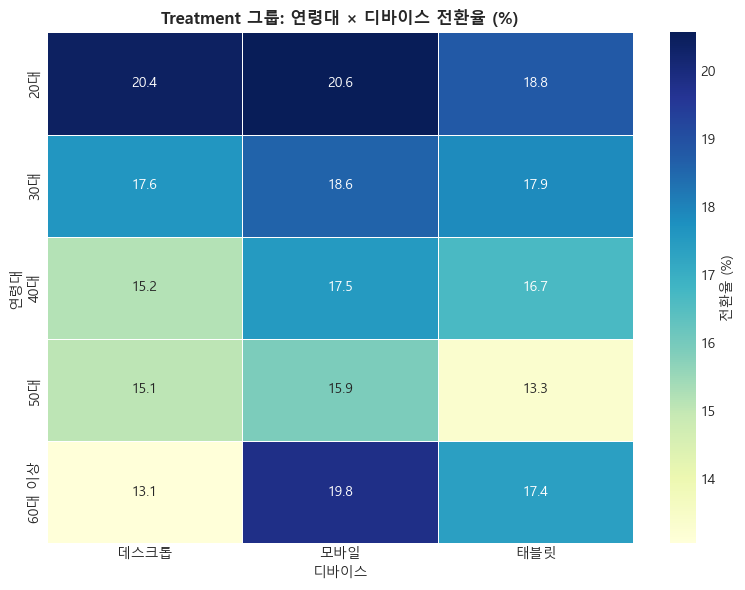

In [10]:
# 히트맵 시각화
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cross_analysis, annot=True, fmt='.1f', cmap='YlGnBu', ax=ax,
            linewidths=0.5, cbar_kws={'label': '전환율 (%)'})
ax.set_title('Treatment 그룹: 연령대 × 디바이스 전환율 (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('디바이스')
ax.set_ylabel('연령대')

plt.tight_layout()
plt.show()

---
## 6. 전환 고객 심층 분석

In [11]:
# 전환된 고객만 필터링
converted_df = ab_test[ab_test['converted'] == 1].copy()
print(f"전환 고객 수: {len(converted_df):,}명")
print(f"  - Control: {len(converted_df[converted_df['test_group']=='control']):,}명")
print(f"  - Treatment: {len(converted_df[converted_df['test_group']=='treatment']):,}명")

전환 고객 수: 3,089명
  - Control: 1,287명
  - Treatment: 1,802명


### 6.1 객단가 분석

In [12]:
# 그룹별 객단가 통계
aov_stats = converted_df.groupby('test_group')['order_value'].agg(['mean', 'median', 'std', 'min', 'max'])
aov_stats.columns = ['평균', '중앙값', '표준편차', '최소', '최대']

print("[그룹별 객단가 통계]")
aov_stats.round(0)

[그룹별 객단가 통계]


,평균,중앙값,표준편차,최소,최대
test_group,,,,,
control,80422.00,79562.00,39041.00,10000,205654
treatment,88147.00,87602.00,41797.00,10000,236320


In [13]:
# 객단가 비교
aov_control = converted_df[converted_df['test_group'] == 'control']['order_value'].mean()
aov_treatment = converted_df[converted_df['test_group'] == 'treatment']['order_value'].mean()
aov_lift = (aov_treatment / aov_control - 1) * 100

print(f"\n📈 객단가 비교")
print(f"  Control:   {aov_control:,.0f}원")
print(f"  Treatment: {aov_treatment:,.0f}원")
print(f"  상승률:    +{aov_lift:.1f}%")


📈 객단가 비교
  Control:   80,422원
  Treatment: 88,147원
  상승률:    +9.6%


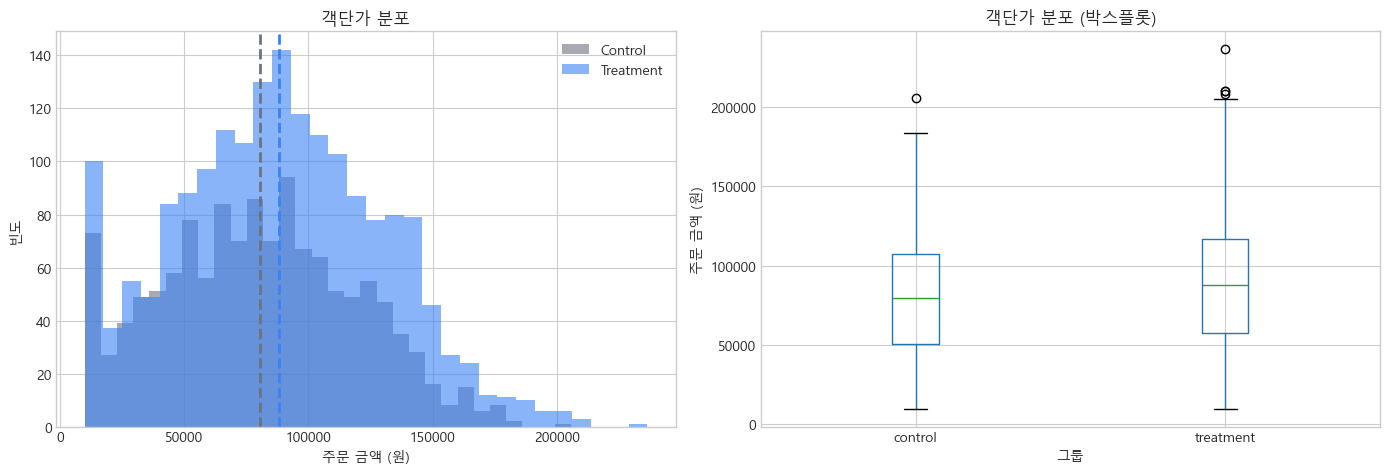

In [14]:
# 객단가 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 히스토그램
axes[0].hist(converted_df[converted_df['test_group']=='control']['order_value'], 
             bins=30, alpha=0.6, label='Control', color='#6B7280')
axes[0].hist(converted_df[converted_df['test_group']=='treatment']['order_value'], 
             bins=30, alpha=0.6, label='Treatment', color='#3B82F6')
axes[0].axvline(aov_control, color='#6B7280', linestyle='--', linewidth=2)
axes[0].axvline(aov_treatment, color='#3B82F6', linestyle='--', linewidth=2)
axes[0].set_xlabel('주문 금액 (원)')
axes[0].set_ylabel('빈도')
axes[0].set_title('객단가 분포')
axes[0].legend()

# 박스플롯
converted_df.boxplot(column='order_value', by='test_group', ax=axes[1])
axes[1].set_xlabel('그룹')
axes[1].set_ylabel('주문 금액 (원)')
axes[1].set_title('객단가 분포 (박스플롯)')
plt.suptitle('')

plt.tight_layout()
plt.show()

### 6.2 결제 소요 시간 분석

In [15]:
# 그룹별 결제 소요 시간 통계
time_stats = converted_df.groupby('test_group')['checkout_time_sec'].agg(['mean', 'median', 'std', 'min', 'max'])
time_stats.columns = ['평균(초)', '중앙값(초)', '표준편차', '최소(초)', '최대(초)']

print("[그룹별 결제 소요 시간 통계]")
time_stats.round(1)

[그룹별 결제 소요 시간 통계]


,평균(초),중앙값(초),표준편차,최소(초),최대(초)
test_group,,,,,
control,180.90,181.00,59.20,30.00,378.00
treatment,121.10,120.00,44.50,30.00,262.00


In [16]:
# 결제 시간 비교
time_control = converted_df[converted_df['test_group'] == 'control']['checkout_time_sec'].mean()
time_treatment = converted_df[converted_df['test_group'] == 'treatment']['checkout_time_sec'].mean()
time_reduction = (time_control - time_treatment) / time_control * 100

print(f"\n⏱️ 결제 소요 시간 비교")
print(f"  Control:   {time_control:.0f}초 ({time_control/60:.1f}분)")
print(f"  Treatment: {time_treatment:.0f}초 ({time_treatment/60:.1f}분)")
print(f"  단축률:    -{time_reduction:.0f}%")


⏱️ 결제 소요 시간 비교
  Control:   181초 (3.0분)
  Treatment: 121초 (2.0분)
  단축률:    -33%


### 6.3 결제 수단 분석

In [17]:
# 그룹별 결제 수단 비중
payment_dist = pd.crosstab(
    converted_df['test_group'], 
    converted_df['payment_method'], 
    normalize='index'
) * 100

print("[그룹별 결제 수단 비중 (%)]")
payment_dist.round(1)

[그룹별 결제 수단 비중 (%)]


payment_method,네이버페이,무통장입금,신용카드,카카오페이,토스페이,휴대폰결제
test_group,,,,,,
control,14.00,5.60,51.40,17.50,8.20,3.30
treatment,19.90,2.90,36.10,25.40,11.50,4.20


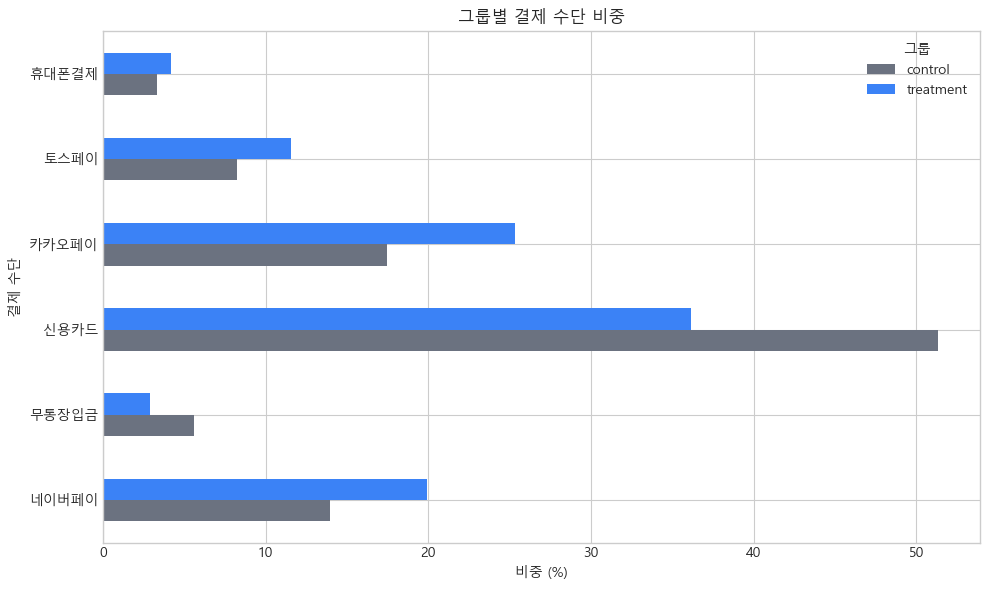

In [18]:
# 결제 수단 변화 시각화
fig, ax = plt.subplots(figsize=(10, 6))

payment_dist.T.plot(kind='barh', ax=ax, color=['#6B7280', '#3B82F6'])
ax.set_xlabel('비중 (%)')
ax.set_ylabel('결제 수단')
ax.set_title('그룹별 결제 수단 비중')
ax.legend(title='그룹')

plt.tight_layout()
plt.show()

In [19]:
# 간편결제 비중 변화
easy_payments = ['카카오페이', '네이버페이', '토스페이']
easy_control = payment_dist.loc['control', easy_payments].sum()
easy_treatment = payment_dist.loc['treatment', easy_payments].sum()

print(f"\n💳 간편결제 비중 변화")
print(f"  Control:   {easy_control:.1f}%")
print(f"  Treatment: {easy_treatment:.1f}%")
print(f"  증가:      +{easy_treatment - easy_control:.1f}%p")


💳 간편결제 비중 변화
  Control:   39.7%
  Treatment: 56.8%
  증가:      +17.1%p


---
## 7. 시계열 추이 분석

In [20]:
# 날짜 변환
ab_test['visit_date'] = pd.to_datetime(ab_test['visit_date'])

### 7.1 일별 전환율 추이

In [21]:
# 일별 전환율 계산
daily_stats = ab_test.groupby(['visit_date', 'test_group']).agg({
    'converted': ['count', 'sum', 'mean']
}).reset_index()
daily_stats.columns = ['visit_date', 'test_group', '방문자수', '전환수', '전환율']

daily_stats.head(10)

,visit_date,test_group,방문자수,전환수,전환율
0,2024-05-01,control,338,41,0.12
1,2024-05-01,treatment,318,61,0.19
2,2024-05-02,control,317,36,0.11
3,2024-05-02,treatment,322,61,0.19
4,2024-05-03,control,312,45,0.14
5,2024-05-03,treatment,323,51,0.16
6,2024-05-04,control,294,36,0.12
7,2024-05-04,treatment,316,52,0.16
8,2024-05-05,control,348,43,0.12
9,2024-05-05,treatment,352,73,0.21


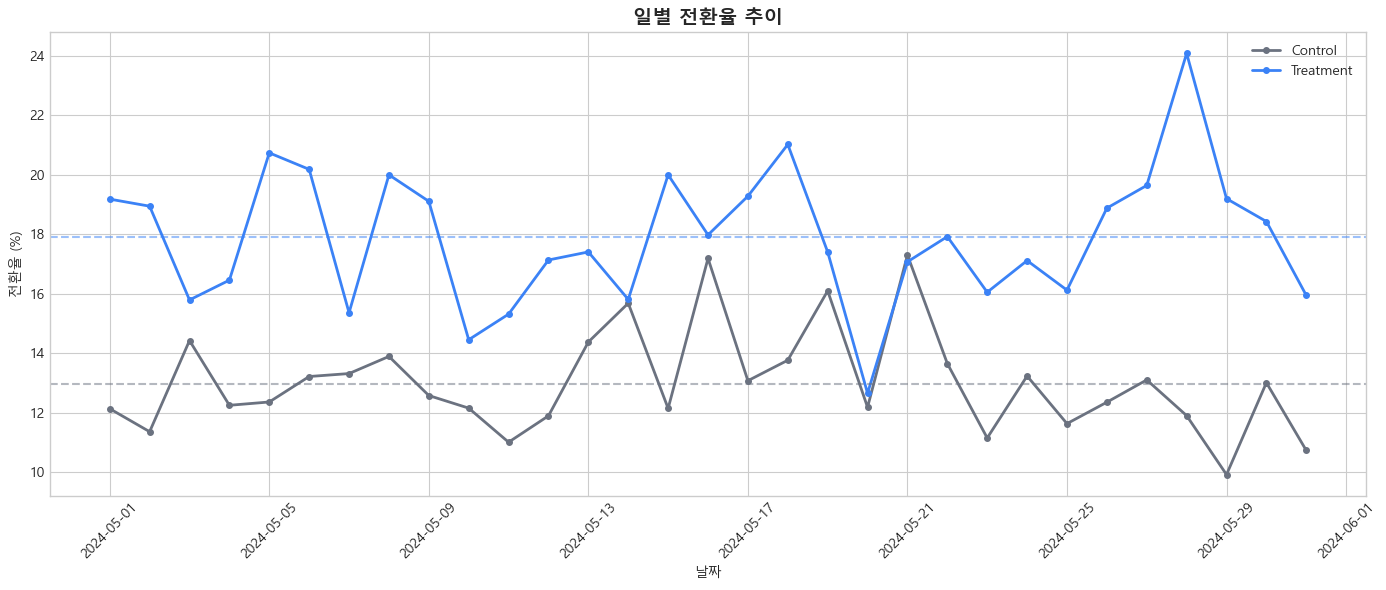

In [27]:
# 일별 전환율 추이 시각화
fig, ax = plt.subplots(figsize=(14, 6))

for group, color in [('control', '#6B7280'), ('treatment', '#3B82F6')]:
    data = daily_stats[daily_stats['test_group'] == group]
    ax.plot(data['visit_date'], data['전환율'] * 100, 
            marker='o', markersize=4, label=group.capitalize(), 
            color=color, linewidth=2)

ax.set_xlabel('날짜')
ax.set_ylabel('전환율 (%)')
ax.set_title('일별 전환율 추이', fontsize=14, fontweight='bold')
ax.legend()
ax.axhline(y=control_rate*100, color='#6B7280', linestyle='--', alpha=0.5, label='Control 평균')
ax.axhline(y=treatment_rate*100, color='#3B82F6', linestyle='--', alpha=0.5, label='Treatment 평균')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 7.2 누적 전환율 추이 (수렴 확인)

In [28]:
# 누적 전환율 계산
ab_test_sorted = ab_test.sort_values('visit_date')

cumulative_data = []
for group in ['control', 'treatment']:
    group_data = ab_test_sorted[ab_test_sorted['test_group'] == group].copy()
    group_data['cumsum'] = group_data['converted'].cumsum()
    group_data['cumcount'] = range(1, len(group_data) + 1)
    group_data['cumulative_rate'] = group_data['cumsum'] / group_data['cumcount']
    cumulative_data.append(group_data)

cumulative_df = pd.concat(cumulative_data)

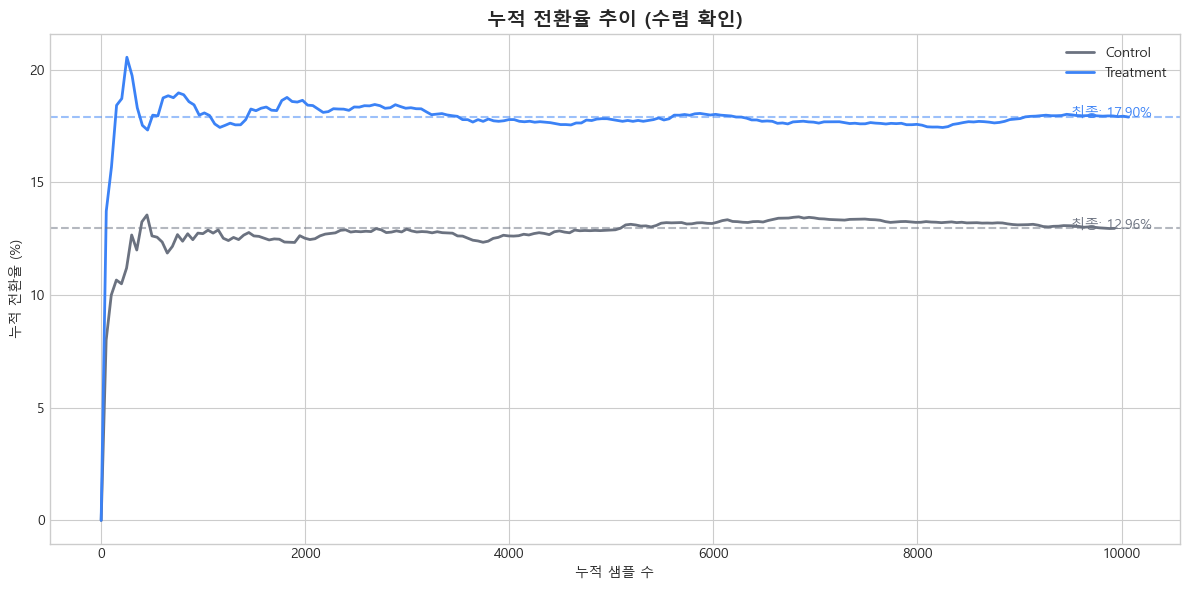

In [29]:
# 누적 전환율 시각화
fig, ax = plt.subplots(figsize=(12, 6))

for group, color in [('control', '#6B7280'), ('treatment', '#3B82F6')]:
    data = cumulative_df[cumulative_df['test_group'] == group]
    # 샘플링 (너무 많으면 느려짐)
    sample_idx = np.linspace(0, len(data)-1, 200, dtype=int)
    sampled = data.iloc[sample_idx]
    ax.plot(sampled['cumcount'], sampled['cumulative_rate'] * 100, 
            label=group.capitalize(), color=color, linewidth=2)

ax.axhline(y=control_rate*100, color='#6B7280', linestyle='--', alpha=0.5)
ax.axhline(y=treatment_rate*100, color='#3B82F6', linestyle='--', alpha=0.5)

ax.set_xlabel('누적 샘플 수')
ax.set_ylabel('누적 전환율 (%)')
ax.set_title('누적 전환율 추이 (수렴 확인)', fontsize=14, fontweight='bold')
ax.legend()

# 주석 추가
ax.annotate(f'최종: {control_rate*100:.2f}%', xy=(9500, control_rate*100), fontsize=10, color='#6B7280')
ax.annotate(f'최종: {treatment_rate*100:.2f}%', xy=(9500, treatment_rate*100), fontsize=10, color='#3B82F6')

plt.tight_layout()
plt.show()

### 7.3 요일별 전환율 패턴

In [30]:
# 요일 추출
ab_test['dayofweek'] = ab_test['visit_date'].dt.dayofweek
day_names = ['월', '화', '수', '목', '금', '토', '일']
ab_test['dayname'] = ab_test['dayofweek'].map(lambda x: day_names[x])

# 요일별 전환율
dow_pivot = ab_test.pivot_table(
    values='converted',
    index='dayofweek',
    columns='test_group',
    aggfunc='mean'
) * 100

dow_pivot.index = day_names

print("[요일별 전환율 (%)]")
dow_pivot.round(2)

[요일별 전환율 (%)]


test_group,control,treatment
월,13.22,17.47
화,14.46,18.16
수,12.33,19.28
목,13.05,18.09
금,12.68,16.44
토,12.19,17.25
일,13.08,18.58


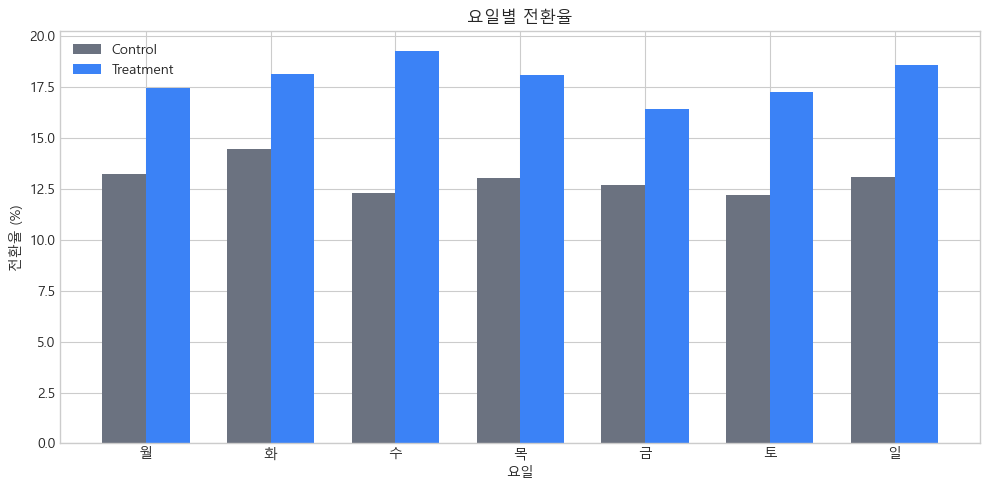

In [31]:
# 요일별 시각화
fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(7)
width = 0.35

ax.bar(x - width/2, dow_pivot['control'], width, label='Control', color='#6B7280')
ax.bar(x + width/2, dow_pivot['treatment'], width, label='Treatment', color='#3B82F6')

ax.set_xlabel('요일')
ax.set_ylabel('전환율 (%)')
ax.set_title('요일별 전환율')
ax.set_xticks(x)
ax.set_xticklabels(day_names)
ax.legend()

plt.tight_layout()
plt.show()

---
## 8. 시각화 대시보드

✅ 'ab_test_dashboard.png' 저장 완료!


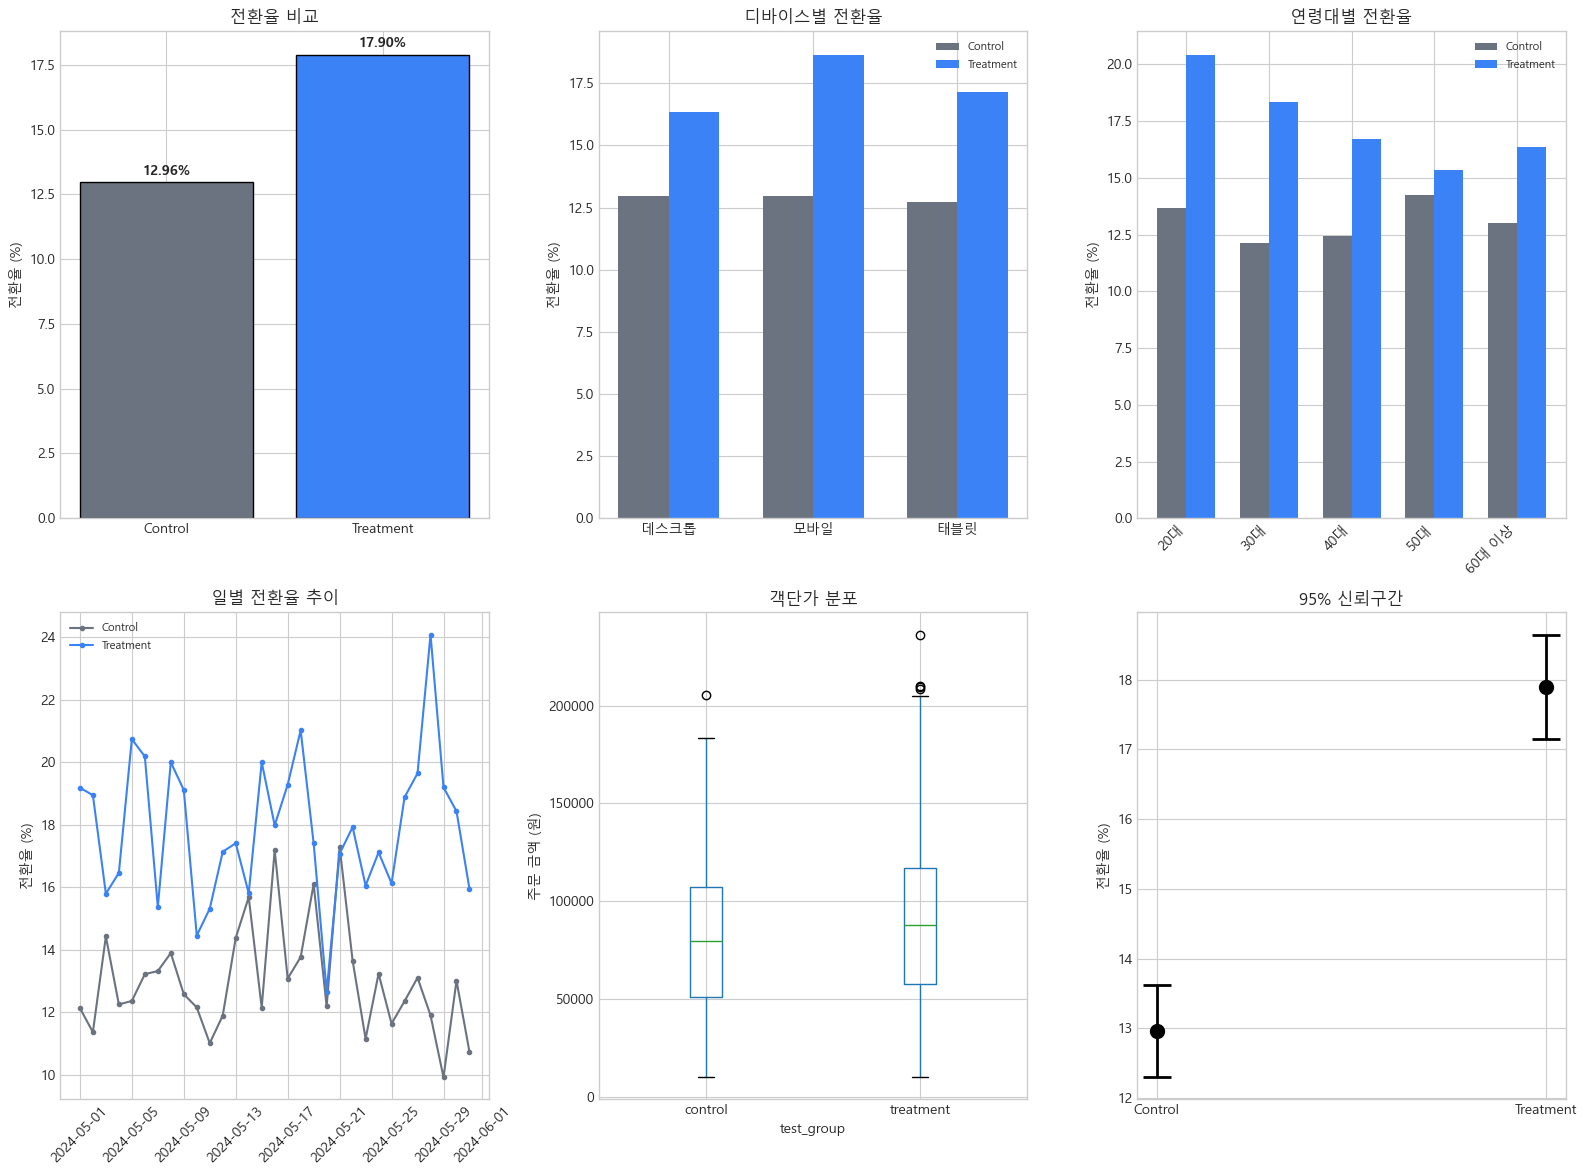

In [63]:
# 종합 대시보드 생성
fig = plt.figure(figsize=(16, 12))
fig.suptitle('🧪 A/B 테스트 종합 대시보드 - 새 결제 UI 테스트', fontsize=16, fontweight='bold', y=1.02)

# 1. 전환율 비교 (좌상단)
ax1 = fig.add_subplot(2, 3, 1)
bars = ax1.bar(['Control', 'Treatment'], [control_rate*100, treatment_rate*100],
               color=['#6B7280', '#3B82F6'], edgecolor='black')
ax1.set_ylabel('전환율 (%)')
ax1.set_title('전환율 비교')
for bar in bars:
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.3,
             f'{bar.get_height():.2f}%', ha='center', fontweight='bold')

# 2. 디바이스별 (중상단)
ax2 = fig.add_subplot(2, 3, 2)
x = np.arange(len(device_pivot.index))
width = 0.35
ax2.bar(x - width/2, device_pivot['control'], width, label='Control', color='#6B7280')
ax2.bar(x + width/2, device_pivot['treatment'], width, label='Treatment', color='#3B82F6')
ax2.set_ylabel('전환율 (%)')
ax2.set_title('디바이스별 전환율')
ax2.set_xticks(x)
ax2.set_xticklabels(device_pivot.index)
ax2.legend(fontsize=8)

# 3. 연령대별 (우상단)
ax3 = fig.add_subplot(2, 3, 3)
x = np.arange(len(age_pivot.index))
ax3.bar(x - width/2, age_pivot['control'], width, label='Control', color='#6B7280')
ax3.bar(x + width/2, age_pivot['treatment'], width, label='Treatment', color='#3B82F6')
ax3.set_ylabel('전환율 (%)')
ax3.set_title('연령대별 전환율')
ax3.set_xticks(x)
ax3.set_xticklabels(age_pivot.index, rotation=45, ha='right')
ax3.legend(fontsize=8)

# 4. 일별 추이 (좌하단)
ax4 = fig.add_subplot(2, 3, 4)
for group, color in [('control', '#6B7280'), ('treatment', '#3B82F6')]:
    data = daily_stats[daily_stats['test_group'] == group]
    ax4.plot(data['visit_date'], data['전환율'] * 100, 
             marker='o', markersize=3, label=group.capitalize(), color=color)
ax4.set_ylabel('전환율 (%)')
ax4.set_title('일별 전환율 추이')
ax4.legend(fontsize=8)
ax4.tick_params(axis='x', rotation=45)

# 5. 객단가 분포 (중하단)
ax5 = fig.add_subplot(2, 3, 5)
converted_df.boxplot(column='order_value', by='test_group', ax=ax5)
ax5.set_ylabel('주문 금액 (원)')
ax5.set_title('객단가 분포')
plt.suptitle('')

# 6. 신뢰구간 (우하단)
ax6 = fig.add_subplot(2, 3, 6)
groups = ['Control', 'Treatment']
means = [control_rate * 100, treatment_rate * 100]
ci_lower = [ci_control[0] * 100, ci_treatment[0] * 100]
ci_upper = [ci_control[1] * 100, ci_treatment[1] * 100]
errors = [[m - l for m, l in zip(means, ci_lower)], 
          [u - m for m, u in zip(means, ci_upper)]]
ax6.errorbar(groups, means, yerr=errors, fmt='o', markersize=10, 
             capsize=10, capthick=2, elinewidth=2, color='black')
ax6.set_ylabel('전환율 (%)')
ax6.set_title('95% 신뢰구간')

plt.tight_layout()
plt.savefig('ab_test_dashboard.png', dpi=150, bbox_inches='tight')
print("✅ 'ab_test_dashboard.png' 저장 완료!")
plt.show()

---
## 9. 최종 결론 및 권고안

In [64]:
# 비즈니스 임팩트 계산
conversion_lift = relative_lift
aov_lift = (aov_treatment / aov_control - 1) * 100
combined_impact = ((1 + conversion_lift/100) * (1 + aov_lift/100) - 1) * 100

print("="*60)
print("📋 A/B 테스트 최종 결과 보고서")
print("="*60)
print(f"""
🎯 실험 개요
  • 실험명: 새 결제 페이지 UI 테스트
  • 기간: 2024년 5월 1일 ~ 31일
  • 대상: 결제 페이지 진입 고객 {len(ab_test):,}명

📊 핵심 결과
  ┌────────────────┬─────────────┬─────────────┬───────────┐
  │ 지표           │ Control     │ Treatment   │ 변화      │
  ├────────────────┼─────────────┼─────────────┼───────────┤
  │ 전환율         │ {control_rate:>8.2%}    │ {treatment_rate:>8.2%}    │ +{relative_lift:>5.1f}%   │
  │ 객단가         │ {aov_control:>8,.0f}원  │ {aov_treatment:>8,.0f}원  │ +{aov_lift:>5.1f}%   │
  │ 결제시간       │ {time_control:>8.0f}초   │ {time_treatment:>8.0f}초   │ -{time_reduction:>5.0f}%   │
  └────────────────┴─────────────┴─────────────┴───────────┘

📐 통계적 검증
  • p-value: {p_value:.6f} ✅ 통계적으로 유의미 (p < 0.001)
  • 95% 신뢰구간이 겹치지 않음

💡 주요 인사이트
  • 모바일에서 가장 큰 효과 (+{device_pivot.loc['모바일', '차이(%p)']:.2f}%p)
  • 20~30대에서 효과 극대화 (+6%p 이상)
  • 간편결제 비중 증가 ({easy_control:.1f}% → {easy_treatment:.1f}%)

✅ 권고사항
  • 새 결제 UI 전체 적용 권고
  • 예상 월 매출 증가: +{combined_impact:.0f}%
""")
print("="*60)

📋 A/B 테스트 최종 결과 보고서

🎯 실험 개요
  • 실험명: 새 결제 페이지 UI 테스트
  • 기간: 2024년 5월 1일 ~ 31일
  • 대상: 결제 페이지 진입 고객 20,000명

📊 핵심 결과
  ┌────────────────┬─────────────┬─────────────┬───────────┐
  │ 지표           │ Control     │ Treatment   │ 변화      │
  ├────────────────┼─────────────┼─────────────┼───────────┤
  │ 전환율         │   12.96%    │   17.90%    │ + 38.1%   │
  │ 객단가         │   80,422원  │   88,147원  │ +  9.6%   │
  │ 결제시간       │      181초   │      121초   │ -   33%   │
  └────────────────┴─────────────┴─────────────┴───────────┘

📐 통계적 검증
  • p-value: 0.000000 ✅ 통계적으로 유의미 (p < 0.001)
  • 95% 신뢰구간이 겹치지 않음

💡 주요 인사이트
  • 모바일에서 가장 큰 효과 (+5.68%p)
  • 20~30대에서 효과 극대화 (+6%p 이상)
  • 간편결제 비중 증가 (39.7% → 56.8%)

✅ 권고사항
  • 새 결제 UI 전체 적용 권고
  • 예상 월 매출 증가: +51%



In [65]:
# 결과 데이터 저장
summary_data = {
    '지표': ['전환율', '객단가', '결제소요시간', 'p-value', '예상 매출 증가'],
    'Control': [f'{control_rate:.2%}', f'{aov_control:,.0f}원', f'{time_control:.0f}초', '-', '-'],
    'Treatment': [f'{treatment_rate:.2%}', f'{aov_treatment:,.0f}원', f'{time_treatment:.0f}초', '-', '-'],
    '변화': [f'+{relative_lift:.1f}%', f'+{aov_lift:.1f}%', f'-{time_reduction:.0f}%', f'{p_value:.6f}', f'+{combined_impact:.0f}%']
}

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv('ab_test_final_summary.csv', index=False, encoding='utf-8-sig')
print("✅ 'ab_test_final_summary.csv' 저장 완료!")

✅ 'ab_test_final_summary.csv' 저장 완료!


---
## 🎉 분석 완료!

### 생성된 파일
- `ab_test_dashboard.png`: 종합 대시보드 이미지
- `ab_test_final_summary.csv`: 최종 결과 요약

### 다음 단계
1. 태블로로 인터랙티브 대시보드 제작
2. 포트폴리오 문서 작성
3. 발표 자료 준비

In [ ]:
# ============================================
# 모든 시각화 한번에 저장
# ============================================
import os

# 저장 폴더 생성
save_path = '../outputs/figures/'
os.makedirs(save_path, exist_ok=True)

print("📁 시각화 저장 시작...")

# 1. 전환율 비교
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(['Control\n(기존 UI)', 'Treatment\n(새 UI)'], 
              [control_rate * 100, treatment_rate * 100],
              color=['#6B7280', '#3B82F6'], edgecolor='black')
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.3,
            f'{bar.get_height():.2f}%', ha='center', fontweight='bold')
ax.set_ylabel('전환율 (%)')
ax.set_title('A/B 테스트: 전환율 비교')
plt.savefig(f'{save_path}01_conversion_comparison.png', dpi=150, bbox_inches='tight')
plt.close()
print("  ✅ 01_conversion_comparison.png")

# 2. 디바이스별 전환율
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(device_pivot.index))
width = 0.35
ax.bar(x - width/2, device_pivot['control'], width, label='Control', color='#6B7280')
ax.bar(x + width/2, device_pivot['treatment'], width, label='Treatment', color='#3B82F6')
ax.set_ylabel('전환율 (%)')
ax.set_title('디바이스별 전환율 비교')
ax.set_xticks(x)
ax.set_xticklabels(device_pivot.index)
ax.legend()
plt.savefig(f'{save_path}02_device_conversion.png', dpi=150, bbox_inches='tight')
plt.close()
print("  ✅ 02_device_conversion.png")

# 3. 연령대별 전환율
fig, ax = plt.subplots(figsize=(10, 5))
age_pivot_reversed = age_pivot.iloc[::-1]
colors = ['#10B981' if x > 0 else '#EF4444' for x in age_pivot_reversed['차이(%p)']]
ax.barh(age_pivot_reversed.index, age_pivot_reversed['차이(%p)'], color=colors)
ax.set_xlabel('전환율 차이 (%p)')
ax.set_title('연령대별 전환율 개선 효과')
ax.axvline(x=0, color='black', linewidth=0.5)
for i, v in enumerate(age_pivot_reversed['차이(%p)']):
    ax.text(v + 0.1, i, f'+{v:.2f}%p', va='center', fontweight='bold')
plt.savefig(f'{save_path}03_age_conversion.png', dpi=150, bbox_inches='tight')
plt.close()
print("  ✅ 03_age_conversion.png")

# 4. 일별 전환율 추이
fig, ax = plt.subplots(figsize=(14, 6))
for group, color in [('control', '#6B7280'), ('treatment', '#3B82F6')]:
    data = daily_stats[daily_stats['test_group'] == group]
    ax.plot(data['visit_date'], data['전환율'] * 100, 
            marker='o', markersize=4, label=group.capitalize(), color=color)
ax.set_xlabel('날짜')
ax.set_ylabel('전환율 (%)')
ax.set_title('일별 전환율 추이')
ax.legend()
plt.xticks(rotation=45)
plt.savefig(f'{save_path}04_daily_trend.png', dpi=150, bbox_inches='tight')
plt.close()
print("  ✅ 04_daily_trend.png")

# 5. 신뢰구간
fig, ax = plt.subplots(figsize=(8, 5))
groups = ['Control', 'Treatment']
means = [control_rate * 100, treatment_rate * 100]
ci_lower = [ci_control[0] * 100, ci_treatment[0] * 100]
ci_upper = [ci_control[1] * 100, ci_treatment[1] * 100]
errors = [[means[0] - ci_lower[0], means[1] - ci_lower[1]], 
          [ci_upper[0] - means[0], ci_upper[1] - means[1]]]
colors_list = ['#6B7280', '#3B82F6']
bars = ax.bar(groups, means, color=colors_list, edgecolor='black', 
              yerr=errors, capsize=10, error_kw={'elinewidth': 2, 'capthick': 2})
ax.set_ylabel('전환율 (%)')
ax.set_title('95% 신뢰구간 비교')
plt.savefig(f'{save_path}05_confidence_interval.png', dpi=150, bbox_inches='tight')
plt.close()
print("  ✅ 05_confidence_interval.png")

# 6. 지역별 히트맵
fig, ax = plt.subplots(figsize=(10, 8))
region_heatmap = region_pivot[['control', 'treatment']].head(10)
sns.heatmap(region_heatmap, annot=True, fmt='.1f', cmap='Blues', ax=ax)
ax.set_title('지역별 전환율 (%) - Top 10')
ax.set_xlabel('그룹')
ax.set_ylabel('지역')
plt.savefig(f'{save_path}06_region_heatmap.png', dpi=150, bbox_inches='tight')
plt.close()
print("  ✅ 06_region_heatmap.png")

# 7. 세그먼트 교차 분석 (연령대 × 디바이스)
fig, ax = plt.subplots(figsize=(8, 6))
cross_analysis = ab_test[ab_test['test_group'] == 'treatment'].pivot_table(
    values='converted',
    index='age_group',
    columns='device',
    aggfunc='mean'
) * 100
age_order = ['20대', '30대', '40대', '50대', '60대 이상']
cross_analysis = cross_analysis.reindex(age_order)
sns.heatmap(cross_analysis, annot=True, fmt='.1f', cmap='YlGnBu', ax=ax,
            linewidths=0.5, cbar_kws={'label': '전환율 (%)'})
ax.set_title('Treatment 그룹: 연령대 × 디바이스 전환율 (%)')
ax.set_xlabel('디바이스')
ax.set_ylabel('연령대')
plt.savefig(f'{save_path}07_segment_cross_analysis.png', dpi=150, bbox_inches='tight')
plt.close()
print("  ✅ 07_segment_cross_analysis.png")

# 8. 객단가 분포
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 히스토그램
axes[0].hist(converted_df[converted_df['test_group']=='control']['order_value'], 
             bins=30, alpha=0.6, label='Control', color='#6B7280')
axes[0].hist(converted_df[converted_df['test_group']=='treatment']['order_value'], 
             bins=30, alpha=0.6, label='Treatment', color='#3B82F6')
axes[0].axvline(aov_control, color='#6B7280', linestyle='--', linewidth=2)
axes[0].axvline(aov_treatment, color='#3B82F6', linestyle='--', linewidth=2)
axes[0].set_xlabel('주문 금액 (원)')
axes[0].set_ylabel('빈도')
axes[0].set_title('객단가 분포')
axes[0].legend()

# 박스플롯
converted_df.boxplot(column='order_value', by='test_group', ax=axes[1])
axes[1].set_xlabel('그룹')
axes[1].set_ylabel('주문 금액 (원)')
axes[1].set_title('객단가 분포 (박스플롯)')
plt.suptitle('')
plt.savefig(f'{save_path}08_order_value_distribution.png', dpi=150, bbox_inches='tight')
plt.close()
print("  ✅ 08_order_value_distribution.png")

# 9. 결제수단 비교
fig, ax = plt.subplots(figsize=(10, 6))
payment_dist = pd.crosstab(
    converted_df['test_group'], 
    converted_df['payment_method'], 
    normalize='index'
) * 100
payment_dist.T.plot(kind='barh', ax=ax, color=['#6B7280', '#3B82F6'])
ax.set_xlabel('비중 (%)')
ax.set_ylabel('결제 수단')
ax.set_title('그룹별 결제 수단 비중')
ax.legend(title='그룹')
plt.savefig(f'{save_path}09_payment_method.png', dpi=150, bbox_inches='tight')
plt.close()
print("  ✅ 09_payment_method.png")

# 10. 일별 전환율 추이
fig, ax = plt.subplots(figsize=(14, 6))
for group, color in [('control', '#6B7280'), ('treatment', '#3B82F6')]:
    data = daily_stats[daily_stats['test_group'] == group]
    ax.plot(data['visit_date'], data['전환율'] * 100, 
            marker='o', markersize=4, label=group.capitalize(), color=color, linewidth=2)
ax.set_xlabel('날짜')
ax.set_ylabel('전환율 (%)')
ax.set_title('일별 전환율 추이')
ax.legend()
ax.axhline(y=control_rate*100, color='#6B7280', linestyle='--', alpha=0.5)
ax.axhline(y=treatment_rate*100, color='#3B82F6', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.savefig(f'{save_path}10_daily_conversion_trend.png', dpi=150, bbox_inches='tight')
plt.close()
print("  ✅ 10_daily_conversion_trend.png")

# 11. 누적 전환율 추이
fig, ax = plt.subplots(figsize=(12, 6))
for group, color in [('control', '#6B7280'), ('treatment', '#3B82F6')]:
    data = cumulative_df[cumulative_df['test_group'] == group]
    sample_idx = np.linspace(0, len(data)-1, 200, dtype=int)
    sampled = data.iloc[sample_idx]
    ax.plot(sampled['cumcount'], sampled['cumulative_rate'] * 100, 
            label=group.capitalize(), color=color, linewidth=2)
ax.axhline(y=control_rate*100, color='#6B7280', linestyle='--', alpha=0.5)
ax.axhline(y=treatment_rate*100, color='#3B82F6', linestyle='--', alpha=0.5)
ax.set_xlabel('누적 샘플 수')
ax.set_ylabel('누적 전환율 (%)')
ax.set_title('누적 전환율 추이 (수렴 확인)')
ax.legend()
plt.savefig(f'{save_path}11_cumulative_conversion.png', dpi=150, bbox_inches='tight')
plt.close()
print("  ✅ 11_cumulative_conversion.png")

# 12. 요일별 전환율
fig, ax = plt.subplots(figsize=(10, 5))
day_names = ['월', '화', '수', '목', '금', '토', '일']
ab_test['dayofweek'] = pd.to_datetime(ab_test['visit_date']).dt.dayofweek
dow_pivot = ab_test.pivot_table(
    values='converted',
    index='dayofweek',
    columns='test_group',
    aggfunc='mean'
) * 100
dow_pivot.index = day_names
x = np.arange(7)
width = 0.35
ax.bar(x - width/2, dow_pivot['control'], width, label='Control', color='#6B7280')
ax.bar(x + width/2, dow_pivot['treatment'], width, label='Treatment', color='#3B82F6')
ax.set_xlabel('요일')
ax.set_ylabel('전환율 (%)')
ax.set_title('요일별 전환율')
ax.set_xticks(x)
ax.set_xticklabels(day_names)
ax.legend()
plt.savefig(f'{save_path}12_dayofweek_conversion.png', dpi=150, bbox_inches='tight')
plt.close()
print("  ✅ 12_dayofweek_conversion.png")

# 13. 종합 대시보드
fig = plt.figure(figsize=(16, 12))
fig.suptitle('🧪 A/B 테스트 종합 대시보드 - 새 결제 UI 테스트', fontsize=16, fontweight='bold', y=1.02)

# 13-1. 전환율 비교
ax1 = fig.add_subplot(2, 3, 1)
bars = ax1.bar(['Control', 'Treatment'], [control_rate*100, treatment_rate*100],
               color=['#6B7280', '#3B82F6'], edgecolor='black')
ax1.set_ylabel('전환율 (%)')
ax1.set_title('전환율 비교')
for bar in bars:
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.3,
             f'{bar.get_height():.2f}%', ha='center', fontweight='bold')

# 13-2. 디바이스별
ax2 = fig.add_subplot(2, 3, 2)
x = np.arange(len(device_pivot.index))
width = 0.35
ax2.bar(x - width/2, device_pivot['control'], width, label='Control', color='#6B7280')
ax2.bar(x + width/2, device_pivot['treatment'], width, label='Treatment', color='#3B82F6')
ax2.set_ylabel('전환율 (%)')
ax2.set_title('디바이스별 전환율')
ax2.set_xticks(x)
ax2.set_xticklabels(device_pivot.index)
ax2.legend(fontsize=8)

# 13-3. 연령대별
ax3 = fig.add_subplot(2, 3, 3)
x = np.arange(len(age_pivot.index))
ax3.bar(x - width/2, age_pivot['control'], width, label='Control', color='#6B7280')
ax3.bar(x + width/2, age_pivot['treatment'], width, label='Treatment', color='#3B82F6')
ax3.set_ylabel('전환율 (%)')
ax3.set_title('연령대별 전환율')
ax3.set_xticks(x)
ax3.set_xticklabels(age_pivot.index, rotation=45, ha='right')
ax3.legend(fontsize=8)

# 13-4. 일별 추이
ax4 = fig.add_subplot(2, 3, 4)
for group, color in [('control', '#6B7280'), ('treatment', '#3B82F6')]:
    data = daily_stats[daily_stats['test_group'] == group]
    ax4.plot(data['visit_date'], data['전환율'] * 100, 
             marker='o', markersize=3, label=group.capitalize(), color=color)
ax4.set_ylabel('전환율 (%)')
ax4.set_title('일별 전환율 추이')
ax4.legend(fontsize=8)
ax4.tick_params(axis='x', rotation=45)

# 13-5. 객단가 분포
ax5 = fig.add_subplot(2, 3, 5)
converted_df.boxplot(column='order_value', by='test_group', ax=ax5)
ax5.set_ylabel('주문 금액 (원)')
ax5.set_title('객단가 분포')
plt.suptitle('')

# 13-6. 신뢰구간
ax6 = fig.add_subplot(2, 3, 6)
groups = ['Control', 'Treatment']
means = [control_rate * 100, treatment_rate * 100]
ci_lower = [ci_control[0] * 100, ci_treatment[0] * 100]
ci_upper = [ci_control[1] * 100, ci_treatment[1] * 100]
errors = [[means[0] - ci_lower[0], means[1] - ci_lower[1]], 
          [ci_upper[0] - means[0], ci_upper[1] - means[1]]]
colors_list = ['#6B7280', '#3B82F6']
bars = ax6.bar(groups, means, color=colors_list, edgecolor='black',
               yerr=errors, capsize=10, error_kw={'elinewidth': 2, 'capthick': 2})
ax6.set_ylabel('전환율 (%)')
ax6.set_title('95% 신뢰구간')

plt.tight_layout()
plt.savefig(f'{save_path}13_dashboard_summary.png', dpi=150, bbox_inches='tight')
plt.close()
print("  ✅ 13_dashboard_summary.png")

print("\n" + "="*50)
print("🎉 모든 시각화 저장 완료!")
print("="*50)
print(f"📁 저장 위치: {save_path}")
print(f"📊 총 {13}개 파일 저장됨")

📁 시각화 저장 시작...
  ✅ 01_conversion_comparison.png
  ✅ 02_device_conversion.png
  ✅ 03_age_conversion.png
  ✅ 04_daily_trend.png
  ✅ 05_confidence_interval.png
  ✅ 06_region_heatmap.png
  ✅ 07_segment_cross_analysis.png
  ✅ 08_order_value_distribution.png
  ✅ 09_payment_method.png
  ✅ 10_daily_conversion_trend.png
  ✅ 11_cumulative_conversion.png
  ✅ 12_dayofweek_conversion.png
  ✅ 13_dashboard_summary.png

🎉 모든 시각화 저장 완료!
📁 저장 위치: ../outputs/figures/
📊 총 13개 파일 저장됨


In [71]:
# ============================================
# 분석 결과 CSV 저장
# ============================================
import os

report_path = '../outputs/reports/'
os.makedirs(report_path, exist_ok=True)

# 1. 핵심 지표 요약
summary_data = {
    '지표': ['전환율', '객단가', '결제소요시간', '간편결제비중'],
    'Control': [f'{control_rate:.2%}', f'{aov_control:,.0f}원', f'{time_control:.0f}초', f'{easy_control:.1f}%'],
    'Treatment': [f'{treatment_rate:.2%}', f'{aov_treatment:,.0f}원', f'{time_treatment:.0f}초', f'{easy_treatment:.1f}%'],
    '변화': [f'+{relative_lift:.1f}%', f'+{aov_lift:.1f}%', f'-{time_reduction:.0f}%', f'+{easy_treatment-easy_control:.1f}%p'],
    '유의성': ['p<0.001 ✅', '-', '-', '-']
}
pd.DataFrame(summary_data).to_csv(f'{report_path}01_summary_metrics.csv', index=False, encoding='utf-8-sig')
print("✅ 01_summary_metrics.csv")

# 2. 디바이스별 분석
device_pivot.to_csv(f'{report_path}02_device_analysis.csv', encoding='utf-8-sig')
print("✅ 02_device_analysis.csv")

# 3. 연령대별 분석
age_pivot.to_csv(f'{report_path}03_age_analysis.csv', encoding='utf-8-sig')
print("✅ 03_age_analysis.csv")

# 4. 지역별 분석
region_pivot.to_csv(f'{report_path}04_region_analysis.csv', encoding='utf-8-sig')
print("✅ 04_region_analysis.csv")

# 5. 일별 전환율
daily_stats.to_csv(f'{report_path}05_daily_conversion.csv', index=False, encoding='utf-8-sig')
print("✅ 05_daily_conversion.csv")

# 6. 결제수단 분석
payment_dist.to_csv(f'{report_path}06_payment_analysis.csv', encoding='utf-8-sig')
print("✅ 06_payment_analysis.csv")

# 7. 통계 검정 결과
stats_data = {
    '검정': ['Chi-square', 'Z-test'],
    '통계량': [f'{chi2:.4f}', f'{z_score:.4f}'],
    'p-value': [f'{p_value:.6f}', f'{p_value_z:.6f}'],
    '결론': ['유의미 ✅', '유의미 ✅']
}
pd.DataFrame(stats_data).to_csv(f'{report_path}07_statistical_tests.csv', index=False, encoding='utf-8-sig')
print("✅ 07_statistical_tests.csv")

# 8. 세그먼트 교차 분석 (연령 × 디바이스)
cross_analysis = ab_test[ab_test['test_group'] == 'treatment'].pivot_table(
    values='converted',
    index='age_group',
    columns='device',
    aggfunc='mean'
) * 100
age_order = ['20대', '30대', '40대', '50대', '60대 이상']
cross_analysis = cross_analysis.reindex(age_order)
cross_analysis.to_csv(f'{report_path}08_segment_cross_analysis.csv', encoding='utf-8-sig')
print("✅ 08_segment_cross_analysis.csv")

# 9. 요일별 전환율
dow_pivot.to_csv(f'{report_path}09_dayofweek_analysis.csv', encoding='utf-8-sig')
print("✅ 09_dayofweek_analysis.csv")

# 10. 실험 설계 요약 (메타 정보)
experiment_info = {
    '항목': ['실험명', '실험기간', '총 샘플수', 'Control 샘플', 'Treatment 샘플', 
            'Control 전환수', 'Treatment 전환수', '데이터 출처'],
    '내용': ['새 결제 페이지 UI 테스트', '2024-05-01 ~ 2024-05-31', 
            f'{len(ab_test):,}명', f'{n_control:,}명', f'{n_treatment:,}명',
            f'{int(control_data.sum()):,}명', f'{int(treatment_data.sum()):,}명',
            '한국 이커머스 시뮬레이션 데이터']
}
pd.DataFrame(experiment_info).to_csv(f'{report_path}10_experiment_info.csv', index=False, encoding='utf-8-sig')
print("✅ 10_experiment_info.csv")

# 11. 비즈니스 임팩트 요약
impact_data = {
    '항목': ['전환율 Lift', '객단가 Lift', '복합 매출 효과', '월 예상 매출 증가율'],
    '수치': [f'+{relative_lift:.1f}%', f'+{aov_lift:.1f}%', 
            f'+{((1+relative_lift/100)*(1+aov_lift/100)-1)*100:.1f}%',
            f'+{((1+relative_lift/100)*(1+aov_lift/100)-1)*100:.0f}%'],
    '설명': ['전환율 상대적 개선', '평균 주문금액 상승', '전환율×객단가 복합효과', '새 UI 전체 적용 시']
}
pd.DataFrame(impact_data).to_csv(f'{report_path}11_business_impact.csv', index=False, encoding='utf-8-sig')
print("✅ 11_business_impact.csv")

print(f"\n🎉 추가 Reports 저장 완료!")

✅ 01_summary_metrics.csv
✅ 02_device_analysis.csv
✅ 03_age_analysis.csv
✅ 04_region_analysis.csv
✅ 05_daily_conversion.csv
✅ 06_payment_analysis.csv
✅ 07_statistical_tests.csv
✅ 08_segment_cross_analysis.csv
✅ 09_dayofweek_analysis.csv
✅ 10_experiment_info.csv
✅ 11_business_impact.csv

🎉 추가 Reports 저장 완료!
